## Loading functions and libraries

In [1]:
import torch, torch.utils.data
import torch.nn as nn
import torch.optim as optim 
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torchvision
import torch.nn.functional as F
from torchvision import datasets, models, transforms

import numpy as np
import gc 
import math
from scipy import stats
import nibabel as ni
from sklearn.model_selection import KFold, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from matplotlib import cm
import os,sys, glob
import trainer_dataugmentation_fix3 as ptt
from PIL import Image
%matplotlib inline
cuda_aval = torch.cuda.is_available()
print('GPU available:',cuda_aval)
import warnings
warnings.filterwarnings("ignore")

GPU available: True


### Auxiliary functions

* Get_labels function receives the slices (with label) from a group of subjects and returns the result of classification and the class probability for each subject, using the indexes of the slices of each one.

* DivisorGenerator function returns the divisors of a given number. This function is used to configure the StratifiedShuffleSplit function that divides the training and validation sets for the application of balanced k-fold.

In [2]:
def get_labels(y_out,ind_end,ind_start,nlabels):
    ind_end_pred = np.add.accumulate(np.array(ind_end)-np.array(ind_start))
    ind_start_pred = np.zeros_like(ind_end_pred)
    ind_start_pred[1:] = ind_end_pred[:-1]

    y_prob_pred = [np.sum(y_out[i:j]==0)/(j-i).astype(float) for i,j in zip(ind_start_pred,ind_end_pred)]
    for label_true in nlabels[1:]:
        y_prob_temp = [np.sum(y_out[i:j]==label_true)/(j-i).astype(float) 
                       for i,j in zip(ind_start_pred,ind_end_pred)]
        y_prob_pred = np.vstack((y_prob_pred,y_prob_temp))
    return y_prob_pred, np.argmax(y_prob_pred,axis=0)

def divisorGenerator(n):
    large_divisors = []
    for i in range(1, int(math.sqrt(n) + 1)):
        if n % i == 0:
            yield i
            if i*i != n:
                large_divisors.append(n / i)
    for divisor in reversed(large_divisors):
        yield divisor


### Loading extended-2D data


In [3]:
dir_bas =   '/home/mariana/Documents/Data_2D/Save/'+'images_total.npy'
dir_bas2 =  '/home/mariana/Documents/Data_2D/Save/'+'labels.npy'
dir_bas3 =  '/home/mariana/Documents/Data_2D/Save/'+'labels_suj.npy'
dir_bas4 =  '/home/mariana/Documents/Data_2D/Save/'+'ind_suj.npy'
dir_bas5 =  '/home/mariana/Documents/Data_2D/Save/'+'n_labels.npy'
dir_bas6 =  '/home/mariana/Documents/Data_2D/Save/'+'num_suj.npy'


images_total = np.load(dir_bas)
labels       = np.load(dir_bas2)
labels_suj   = np.load(dir_bas3)
ind_suj      = np.load(dir_bas4)
n_labels     = np.load(dir_bas5)
num_suj      = np.load(dir_bas6)

In [4]:
print(images_total.shape)
print(labels.shape)
print(labels_suj.shape)
print(ind_suj.shape)
print(n_labels.shape)
print(num_suj)

(10460, 3, 140, 140)
(10460, 1)
(523,)
(524,)
(3,)
523


## Model


Transfer learning using ResNet34. All weights of the pre-trained model were frozen.

In [5]:
class MyResNetConv(torch.nn.Module):
    def __init__(self, fixed_feature=True):
        super().__init__()
        self.my_resnet34_model = models.resnet34(pretrained=True)
        del self.my_resnet34_model.layer3
        del self.my_resnet34_model.layer4
        del self.my_resnet34_model.fc
        for param in self.parameters():
            param.requires_grad = False
    def forward(self, x):        
        x = self.my_resnet34_model.conv1(x)
        x = self.my_resnet34_model.bn1(x)
        x = self.my_resnet34_model.relu(x)
        x = self.my_resnet34_model.maxpool(x)
        x = self.my_resnet34_model.layer1(x)
        x = self.my_resnet34_model.layer2(x) 
        x = self.my_resnet34_model.avgpool(x)
        x = x.view(x.size(0), -1)
        return x

class MyResNetDens(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.dens3 = torch.nn.Linear(in_features=128, out_features=64)
        self.drop3 = torch.nn.Dropout2d(p=0.25)
        self.dens4 = torch.nn.Linear(in_features=64, out_features=3) 

    def forward(self, x):
        x = self.dens3(x)
        x = torch.nn.functional.relu(x)
        x = self.drop3(x)
        x = self.dens4(x)

        return x

class MyResNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mrnc = MyResNetConv()
        self.mrnd = MyResNetDens()
        
    def forward(self, x):
        x = self.mrnc(x)
        #print(x.size())
        x = self.mrnd(x)
        return x

model = MyResNet()
if cuda_aval:
    model = model.cuda()
print(model)

MyResNet(
  (mrnc): MyResNetConv(
    (my_resnet34_model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchN

## Training the model

In [10]:
inp_set = torch.Tensor(images_total)
if cuda_aval:
    inp_set = inp_set.cuda()
feat_set = inp_set

print(feat_set.size())

torch.Size([10460, 3, 100, 100])


In [6]:
n_epochs = 1000
criterion = torch.nn.CrossEntropyLoss()
data_transf = transforms.Compose([ptt.RandomCrop(64)])

In [12]:
del images_total
del inp_set
gc.collect()

120

In [13]:
skf = StratifiedShuffleSplit(n_splits=2, test_size=100, train_size=423, random_state=996622)
batch_size = 100 
X = np.arange(num_suj)
acc_kfold = [] 
fold = 0
trainer = {}
final_loss_train = np.array([]).reshape(0,n_epochs)
final_loss_valid = np.array([]).reshape(0,n_epochs)
final_acc_train = np.array([]).reshape(0,n_epochs)
final_acc_valid = np.array([]).reshape(0,n_epochs)
for train_s, valid_s in skf.split(X, labels_suj):
    model = MyResNet()
    if cuda_aval:
        model = model.cuda()
        
    optimizer = optim.Adam(model.mrnd.parameters(), lr=0.00005)
    fp_model = './model600regRGB_Opt64{}'.format(fold)
    cb_chkpt = ptt.ModelCheckpoint(fp_model, reset=True, verbose=1)

    trainer["string{0}".format(fold)] = ptt.DeepNetTrainer(model = model, criterion = criterion, optimizer = optimizer,
                                        data_transf = data_transf,
                                        #lr_scheduler  = schd,
                                        callbacks = [ptt.AccuracyMetric(), cb_chkpt, ptt.PrintCallback()])

    ind_start_train = np.take(ind_suj[:-1],train_s)
    ind_end_train = np.take(ind_suj[1:],train_s)
    
    x_train = torch.cat([feat_set[i:j] for i,j in zip(ind_start_train,ind_end_train)])
    labels_train = np.concatenate([labels[i:j] for i,j in zip(ind_start_train,ind_end_train)])
    y_train = torch.LongTensor(labels_train)
    
    ind_start_valid = np.take(ind_suj[:-1],valid_s)
    ind_end_valid = np.take(ind_suj[1:],valid_s)
    
    x_valid = torch.cat([feat_set[i:j] for i,j in zip(ind_start_valid,ind_end_valid)])
    labels_valid = np.concatenate([labels[i:j] for i,j in zip(ind_start_valid,ind_end_valid)])
    y_valid_true = labels_suj[valid_s].astype("uint8")
    y_valid = torch.LongTensor(labels_valid)
    
    train_loader = DataLoader(ptt.create_dataloaders(x_train, y_train, transform=data_transf), 
                              batch_size=batch_size, shuffle=True)
    
 
    
    valid_loader = DataLoader(ptt.create_dataloaders(x_valid, y_valid, transform=data_transf),
                              batch_size=batch_size, shuffle=True) 

    trainer["string{0}".format(fold)].fit_loader(n_epochs, train_loader, valid_data=valid_loader)

    
    final_loss_train = np.vstack((final_loss_train,trainer["string{0}".format(fold)].metrics['train']['losses']))
    final_loss_valid = np.vstack((final_loss_valid,trainer["string{0}".format(fold)].metrics['valid']['losses']))
    final_acc_train = np.vstack((final_acc_train,trainer["string{0}".format(fold)].metrics['train']['acc']))
    final_acc_valid = np.vstack((final_acc_valid,trainer["string{0}".format(fold)].metrics['valid']['acc']))
    
    del x_train, y_train, x_valid, y_valid, train_loader, valid_loader
    gc.collect()
    fold += 1


Start training for 1000 epochs
  1:   1.7s   T: 1.10209 0.33392   V: 1.09899 0.33950 best
  2:   1.3s   T: 1.09856 0.34645   V: 1.09769 0.35450 best
  3:   1.2s   T: 1.09815 0.35461   V: 1.09723 0.36150 best
  4:   1.2s   T: 1.09762 0.35591   V: 1.09686 0.37800 best
  5:   1.3s   T: 1.09722 0.35898   V: 1.09561 0.38950 best
  6:   1.2s   T: 1.09701 0.36395   V: 1.09520 0.40050 best
  7:   1.2s   T: 1.09552 0.37719   V: 1.09508 0.39700 best
  8:   1.2s   T: 1.09543 0.37730   V: 1.09410 0.41650 best
  9:   1.2s   T: 1.09483 0.38073   V: 1.09342 0.41400 best
 10:   1.3s   T: 1.09365 0.38853   V: 1.09294 0.40950 best
 11:   1.2s   T: 1.09340 0.39019   V: 1.09200 0.41950 best
 12:   1.2s   T: 1.09297 0.39752   V: 1.09171 0.42450 best
 13:   1.3s   T: 1.09151 0.39303   V: 1.09083 0.41900 best
 14:   1.2s   T: 1.09130 0.39965   V: 1.09040 0.41600 best
 15:   1.2s   T: 1.09036 0.40650   V: 1.08864 0.42950 best
 16:   1.2s   T: 1.09020 0.40355   V: 1.08789 0.42550 best
 17:   1.2s   T: 1.08847 

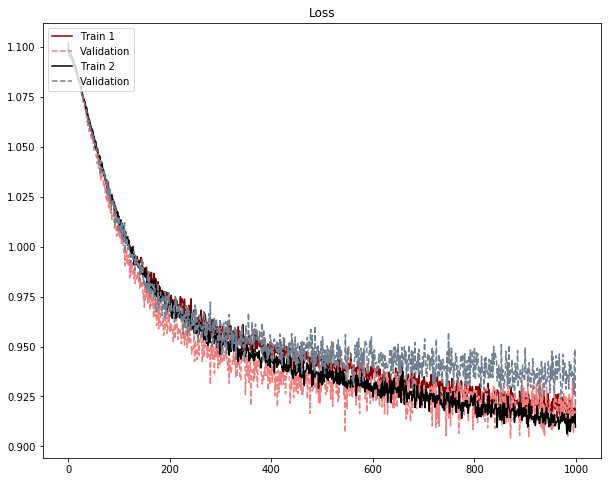

In [16]:
fig = plt.figure(figsize=(10,8))
fold = 2
colors2 = np.array(['maroon', 'k','olive','orange', 'blue','green','blue'])
colors1 = np.array(['lightcoral','slategrey','darkseagreen', 'darkgoldenrod', 'slateblue' ])
labels_kfold = np.array(['Fold 1','Fold 2', 'Fold 3','Fold 4','Fold 5','Fold 6'])
labels_kfold = np.array(['Train 1', 'Train 2',  'Train 3', 'Train 4' ,'Train 5'])
labels_kfold2 = np.array(['Validation','Validation','Validation', 'Validation','Validation'])

for i in range(fold):
    plt.plot(final_loss_train[i,:], color=colors2[i], label=labels_kfold[i])
    plt.grid()
    plt.plot(final_loss_valid[i,:], color=colors1[i], linestyle= 'dashed', label=labels_kfold2[i])
    
    plt.grid()
    plt.title('Loss') 
    plt.legend(loc= 'upper left')  

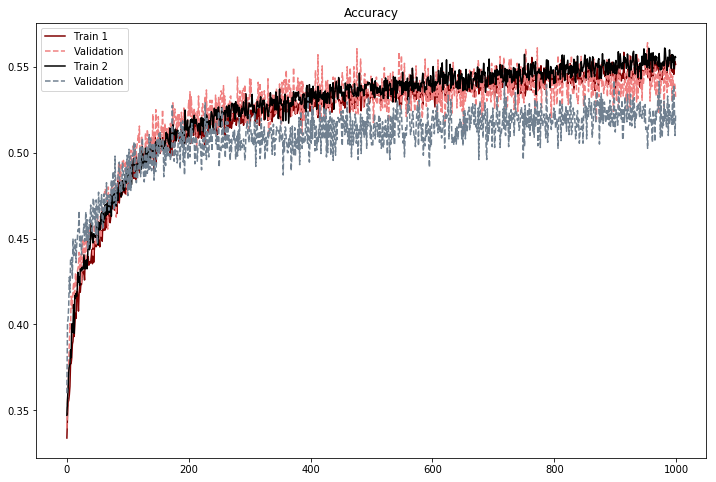

In [17]:
fig = plt.figure(figsize=(12,8))
fold = 2 
colors2 = np.array(['maroon', 'k','olive','orange', 'blue','green','blue'])
colors1 = np.array(['lightcoral','slategrey','darkseagreen', 'darkgoldenrod', 'slateblue' ])
labels_kfold = np.array(['Fold 1','Fold 2', 'Fold 3','Fold 4','Fold 5','Fold 6'])
labels_kfold = np.array(['Train 1', 'Train 2',  'Train 3', 'Train 4' ,'Train 5'])
labels_kfold2 = np.array(['Validation','Validation','Validation', 'Validation','Validation'])

for i in range(fold):
    plt.plot(final_acc_train[i,:], color=colors2[i], label=labels_kfold[i])
    plt.plot(final_acc_valid[i,:], color=colors1[i], linestyle= 'dashed', label=labels_kfold2[i]) 
    plt.grid()
    plt.title('Accuracy') 
    plt.legend(loc= 'upper left')  

### Loading the test extended-2D data

In [7]:
dir_bas =   '/home/mariana/Documents/Data_2D/Save/'+'images_total_t.npy'
dir_bas2 =  '/home/mariana/Documents/Data_2D/Save/'+'labels_t.npy'
dir_bas3 =  '/home/mariana/Documents/Data_2D/Save/'+'labels_suj_t.npy'
dir_bas4 =  '/home/mariana/Documents/Data_2D/Save/'+'ind_suj_t.npy'
dir_bas5 =  '/home/mariana/Documents/Data_2D/Save/'+'n_labels_t.npy'
dir_bas6 =  '/home/mariana/Documents/Data_2D/Save/'+'num_suj_t.npy'

images_total = np.load(dir_bas)
labels       = np.load(dir_bas2)
labels_suj   = np.load(dir_bas3)
ind_suj      = np.load(dir_bas4)
n_labels     = np.load(dir_bas5)
num_suj      = np.load(dir_bas6)

In [9]:
print(images_total.shape)
print(labels.shape)
print(labels_suj.shape)
print(ind_suj.shape)
print(n_labels.shape)
print(num_suj)

(1180, 3, 100, 100)
(1180, 1)
(59,)
(60,)
(3,)
59


In [10]:
print(__doc__)

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

class_names = ["AD","MCI","NC"]

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Automatically created module for IPython interactive environment


(1180,)
[[ 0.1   0.45  0.35  0.    0.2   0.6   0.    0.2   0.05  0.    0.05  0.65
   0.35  0.45  0.    0.15  0.    0.75  0.05  0.4   0.6   0.    0.6   0.05
   0.05  0.65  0.05  0.05  0.05  0.    0.    0.55  0.25  0.05  0.1   0.25
   0.7   0.35  0.    0.65  0.25  0.    0.    0.3   0.05  0.15  0.15  0.4
   0.15  0.1   0.65  0.05  0.3   0.35  0.15  0.3   0.35  0.45  0.  ]
 [ 0.15  0.1   0.6   0.45  0.05  0.    0.    0.3   0.95  0.1   0.1   0.15
   0.6   0.5   0.05  0.15  1.    0.15  0.    0.5   0.4   0.1   0.35  0.1
   0.85  0.05  0.95  0.05  0.    0.05  0.05  0.2   0.45  0.    0.    0.75
   0.15  0.    1.    0.05  0.65  0.    0.3   0.15  0.85  0.    0.2   0.6
   0.85  0.85  0.05  0.9   0.25  0.1   0.05  0.1   0.3   0.5   0.  ]
 [ 0.75  0.45  0.05  0.55  0.75  0.4   1.    0.5   0.    0.9   0.85  0.2
   0.05  0.05  0.95  0.7   0.    0.1   0.95  0.1   0.    0.9   0.05  0.85
   0.1   0.3   0.    0.9   0.95  0.95  0.95  0.25  0.3   0.95  0.9   0.
   0.15  0.65  0.    0.3   0.1   1.    0.7   0

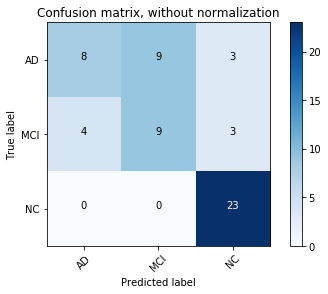

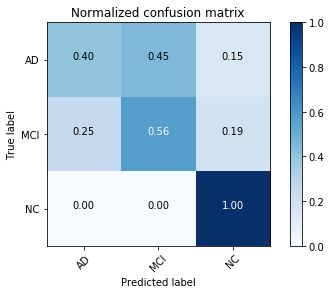

(1180,)
[[ 0.15  0.55  0.35  0.    0.2   0.45  0.    0.4   0.15  0.05  0.05  0.7
   0.4   0.55  0.    0.15  0.    0.8   0.    0.55  0.6   0.05  0.8   0.2
   0.4   0.55  0.25  0.1   0.    0.05  0.    0.65  0.4   0.05  0.05  0.4
   0.5   0.25  0.    0.75  0.35  0.05  0.    0.05  0.1   0.15  0.2   0.55
   0.45  0.25  0.8   0.25  0.35  0.25  0.2   0.2   0.5   0.45  0.  ]
 [ 0.1   0.05  0.65  0.6   0.1   0.1   0.    0.05  0.85  0.    0.05  0.05
   0.55  0.4   0.    0.1   1.    0.15  0.05  0.25  0.35  0.2   0.1   0.05
   0.6   0.    0.75  0.1   0.1   0.1   0.    0.1   0.35  0.    0.05  0.6
   0.25  0.    1.    0.    0.65  0.05  0.2   0.05  0.9   0.05  0.15  0.4
   0.5   0.75  0.05  0.7   0.1   0.25  0.    0.1   0.2   0.55  0.1 ]
 [ 0.75  0.4   0.    0.4   0.7   0.45  1.    0.55  0.    0.95  0.9   0.25
   0.05  0.05  1.    0.75  0.    0.05  0.95  0.2   0.05  0.75  0.1   0.75
   0.    0.45  0.    0.8   0.9   0.85  1.    0.25  0.25  0.95  0.9   0.
   0.25  0.75  0.    0.25  0.    0.9   0.8   0.

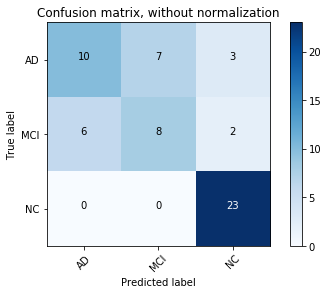

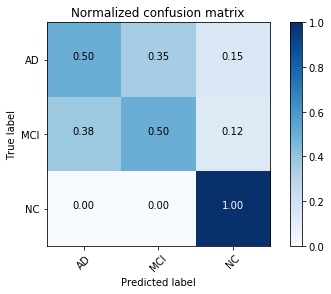

In [22]:
inp_test = torch.Tensor(images_total)
if cuda_aval:
    inp_test = inp_test.cuda()
f = 2

for f in range(f):
    fp_model = './model600regRGB_Opt64{}'.format(f)

    optimizer = optim.Adam(model.mrnd.parameters(), lr=0.00005)#, momentum=0.8)
    cb_chkpt = ptt.ModelCheckpoint(fp_model, reset=True, verbose=1) 
    criterion = torch.nn.CrossEntropyLoss()
    data_transf = transforms.Compose([ptt.RandomCrop(64)])

    model_test = ptt.DeepNetTrainer(model = model, criterion = criterion, optimizer = optimizer,
                                            data_transf = data_transf,
                                            #lr_scheduler  = schd,
                                            callbacks = [ptt.AccuracyMetric(), cb_chkpt, ptt.PrintCallback()])

    model_test.load_state(fp_model)
    y_better_out = model_test.predict(inp_test, labels)

    #y_better_out = trainer["string6"].predict(images, labels)
    __, y_better_out = torch.max(y_better_out, 1)
    y_better_out = y_better_out.cpu().numpy()
    print(y_better_out.shape)

    y_prob_pred, y_better_pred = get_labels(y_better_out,ind_suj[1:],ind_suj[:-1],n_labels)
    print(y_prob_pred)
    acc_k = accuracy_score(labels_suj, y_better_pred)
    print(acc_k)
    print(labels_suj.astype(int))
    print(y_better_pred)
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(labels_suj, y_better_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()